## PART 1 - Processing text to create design matrices

In [183]:
import pandas as pd
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                   delimiter="\t", quoting=3)

The training data contains 25,000 reviews, each with a binary sentiment score and ID.

In [184]:
print train.shape
print train.columns.values

(25000, 3)
['id' 'sentiment' 'review']


In [141]:
!pip install BeautifulSoup4
from bs4 import BeautifulSoup

In [10]:
import re

In [11]:
import nltk
nltk.download(['stopwords'])
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Given a raw review, the function review_to_words will clean the text to remove HTML markup, stop words, and all punctuation and numbers. 

In [185]:
def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub("[^a-zA-z]", " ", review_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return " ".join(meaningful_words)

This function can now be used to iterate through the training data and make a new list of cleaned reviews.

In [186]:
num_reviews = train['review'].size
clean_train_reviews = []
sentiments_train = []

print "Cleaning and parsing the movie reviews training set...\n"
for i in xrange(0, num_reviews):
    clean_train_reviews.append(review_to_words(train['review'][i]))
    sentiments_train.append(train['sentiment'][i])
    if( (i+1)%1000 == 0 ):
        print "Review %d of %d\n" % ( i+1, num_reviews )

Cleaning and parsing the movie reviews training set...

Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



Now we can use clean_train_words to create a bag of words using sklearn's feature extraction methods. We limit the size of the vocabulary to 5000 words and create the X_counts array to house the raw words counts.

In [187]:
print "Creating the bag of words...\n"
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)
X_counts = train_data_features.toarray()

Creating the bag of words...



We can now transform X_counts into a binary matrix X_binary, where counts greater than 0 become 1 and counts of 0 remain as they were.

In [145]:
X_binary = []
for review in X_counts:
    review_binary = []
    for count in review:
        if count > 0: 
            review_binary.append(1)
        else:
            review_binary.append(0)
    X_binary.append(review_binary)

We can use sklearn's tfidf vectorizer to get the X_tfidf term-frequency inverse document-frequency matrix

In [146]:
from sklearn.feature_extraction.text import TfidfTransformer

In [147]:
transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = transformer.fit_transform(X_counts)
X_tfidf = X_tfidf.toarray()

Create X_binary_imabalnce that will delete 75% of reviews with sentiment=1 to create an imabalanced dataset.

In [148]:
import numpy as np

X_binary_imbalance = []
Y_binary_imbalance = []
X_1 = []
Y_1 = []
for i in range(len(X_binary)):
    if sentiments_train[i] == 1:
        X_1.append(X_binary[i])
        Y_1.append(sentiments_train[i])
    else:
        X_binary_imbalance.append(X_binary[i])
        Y_binary_imbalance.append(sentiments_train[i])
        
# take X_1 and delete 75% of its rows randomly
# first, select random indeces to keep

random_indeces = np.random.choice(len(X_1), len(X_1)//4)
for index in random_indeces:
    X_binary_imbalance.append(X_1[int(index)])
    Y_binary_imbalance.append(Y_1[int(index)])

## PART 2 - Feature Space Similarity Experiment

Let dist(X, i, j, distance_function=’Euclidean’) be a function which returns the (Euclidean) distance between rows i and j of a design matrix. Import scipy to make the calculation efficient.

In [149]:
import scipy

In [150]:
def dist(X,i,j,distance_function='Euclidean'):
    matrix = [X[i],X[j]]
    return scipy.spatial.distance.pdist(matrix, 'euclidean')

Let topk(X, k) be a function which returns ((i1,j1,d1),...(ik,jk,dk)) where (ix,jx) are the indices of the xth closest pair, and dx is the corresponding distance.

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix, coo_matrix
from itertools import izip

In [ ]:
def topk(X,k):
    distances = euclidean_distances(X,X)
    rows = len(distances)
    cols = len(distances[0])
    mindist = 1e6
    topK = [(0,0,0)]
    K = 0
    while K < k:
        for r in range(rows):
            for c in range(cols):
                d = distances[r][c]
                if d < mindist and d!=0 and d > topK[K][2]:
                    mindist = d
                    smallest = (r,c,mindist)
                    
        ro,co,di = smallest[0],smallest[1],smallest[2]
        if ((co,ro,di) not in topK) and ((ro,co,di) not in topK):
            topK.append(smallest)
            K += 1
    return topK

In [22]:
def topk(X,k):
    X = csr_matrix(X)
    
    print "calculating distances..."
    distances = coo_matrix(euclidean_distances(X,X))
    print "assembling tuples..."
    
    tuples = izip(distances.row, distances.col, distances.data)
    #tup_sort = sorted(tuples, key=lambda x: (x[2]))
    dtype = [('row',int),('col',int),('dist',float)]
    values = [x for x in tuples]
    arr = np.array(values,dtype=dtype)
    
    print 'sorting matrix...'
    sorted = np.sort(arr,order='dist')
    print 'done sorting'
    
    # now get the first k unique elements from tup_sort
    topk = []
    i, skips = 0,0
    while i < (k+skips):
        if i > 0 and (tup_sort[i][0] == aaa[i-1][1])\
                and (tup_sort[i][1] == tup_sort[i-1][0]):
            skips += 1
            i += 1
        else:
            topk.append(tup_sort[i])
            i += 1
    return topk

## PART 3 - Classification Experiment

Split each design matrix into an 80% - 20% training set - test set split.

In [30]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from random import uniform

In [151]:
Y = sentiments_train

X_counts_train, X_counts_test, y_train, y_test = train_test_split(X_counts, Y, train_size = 0.8, random_state=0)
X_binary_train, X_binary_test, y_train, y_test = train_test_split(X_binary, Y, train_size = 0.8, random_state=0)
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, Y, train_size = 0.8, random_state=0)
X_BI_train, X_BI_test, y_BI_train, y_BI_test = train_test_split(X_binary_imbalance, Y_binary_imbalance, train_size = 0.8, random_state=0)

Train a Support Vector Machine with a linear kernel, trying different values of C.
Design matrices trained in this order:
1) X_counts 
2) X_binary 
3) X_tfidf 
4) X_binary_imbalance

In [35]:
avgs = [] #X_counts results
for i in range(30):
    c = uniform(1e-4,1e4)
    clf = svm.LinearSVC(C=c)
    score = cross_val_score(clf, (X_counts_train), (y_train), cv=5, scoring='roc_auc').mean()
    avgs.append((c,score))

In [55]:
binavgs = [] #X_binary results
for i in range(30):
    c = uniform(1e-4,1e4)
    clf = svm.LinearSVC(C=c)
    score = cross_val_score(clf, (X_binary_train), (y_train), cv=5, scoring='roc_auc').mean()
    binavgs.append((c,score))

In [56]:
tfidfavgs = [] #X_tfidf results
for i in range(30):
    c = uniform(1e-4,1e4)
    clf = svm.LinearSVC(C=c)
    score = cross_val_score(clf, (X_tfidf_train), (y_train), cv=5, scoring='roc_auc').mean()
    tfidfavgs.append((c,score))

In [152]:
BIavgs = [] #X_binary_imbalance results
for i in range(30):
    c = uniform(1e-4,1e4)
    clf = svm.LinearSVC(C=c)
    score = cross_val_score(clf, (X_BI_train), (y_BI_train), cv=5, scoring='roc_auc').mean()
    BIavgs.append((c,score))

In [65]:
def getBestC(matrixName,avgs):
    maxC = 0
    maxScore = 0
    for c in avgs:
        if c[1] > maxScore:
            maxC = c[0]
            maxScore = c[1]
    print matrixName + ":\n"
    print "Best C value: " + str(maxC) + "\nROC AUC score: " + str(maxScore) + '\n'

With the experiments performed, we now have the best C value that achieved the highest ROC AUC score for each design matrix.

In [153]:
getBestC("X_counts",avgs)
getBestC("X_binary",binavgs)
getBestC("X_tfidf",tfidfavgs)
getBestC("X_binary_imbalance",BIavgs)

X_counts:

Best C value: 6497.44080823
ROC AUC score: 0.895413854694

X_binary:

Best C value: 6705.98625454
ROC AUC score: 0.896784061064

X_tfidf:

Best C value: 482.452969091
ROC AUC score: 0.904360115232

X_binary_imbalance:

Best C value: 61.7598652458
ROC AUC score: 0.901109835463



With these optimal C values, each model will be retrained using the entire training data. Then a ROC curve will be generated.

In [102]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [156]:
clf = svm.LinearSVC(C=6497.44080823) #X_counts
y_score = clf.fit(X_counts_train, y_train).decision_function(X_counts_test)

# Compute ROC curve and ROC area for each class
XCfpr, XCtpr, threshholds = roc_curve(y_test, y_score, pos_label=1)
XCauc = auc(XCfpr, XCtpr)

In [157]:
clf = svm.LinearSVC(C=6705.98625454) #X_binary
y_score = clf.fit(X_binary_train, y_train).decision_function(X_binary_test)

# Compute ROC curve and ROC area for each class
XBfpr, XBtpr, threshholds = roc_curve(y_test, y_score, pos_label=1)
XBauc = auc(XBfpr, XBtpr)

In [158]:
clf = svm.LinearSVC(C=482.452969091) #X_tfidf
y_score = clf.fit(X_tfidf_train, y_train).decision_function(X_tfidf_test)

# Compute ROC curve and ROC area for each class
XTfpr, XTtpr, threshholds = roc_curve(y_test, y_score, pos_label=1)
XTauc = auc(XTfpr, XTtpr)

In [159]:
clf = svm.LinearSVC(C=61.7598652458) #X_binary_imbalance
y_score = clf.fit(X_BI_train, y_BI_train).decision_function(X_BI_test)

# Compute ROC curve and ROC area for each class
XBIfpr, XBItpr, threshholds = roc_curve(y_BI_test, y_score, pos_label=1)
XBIauc = auc(XBIfpr, XBItpr)

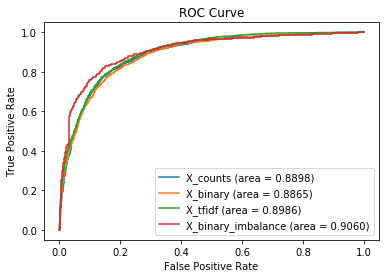

In [160]:
plt.figure()
plt.plot(XCfpr, XCtpr, label='X_counts (area = %0.4f)' % XCauc)
plt.plot(XBfpr, XBtpr, label='X_binary (area = %0.4f)' % XBauc)
plt.plot(XTfpr, XTtpr, label='X_tfidf (area = %0.4f)' % XTauc)
plt.plot(XBIfpr, XBItpr,label='X_binary_imbalance (area = %0.4f)' % XBIauc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Now, download Kaggle test data and construct the four design matrices.

Create X_counts design matrix.

In [188]:
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print test.shape

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print "Cleaning and parsing the test set movie reviews...\n"
for i in xrange(0,num_reviews):
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
X_countsTEST = test_data_features.toarray()

(25000, 2)
Cleaning and parsing the test set movie reviews...



Create X_binary design matrix.

In [193]:
X_binaryTEST = []
for review in X_countsTEST:
    review_binary = []
    for count in review:
        if count > 0: 
            review_binary.append(1)
        else:
            review_binary.append(0)
    X_binaryTEST.append(review_binary)

Create X_tfidf design matrix.

In [195]:
transformer = TfidfTransformer(smooth_idf=False)
X_tfidfTEST = transformer.fit_transform(X_countsTEST)
X_tfidfTEST = X_tfidfTEST.toarray()

Now train each classifier with the corresponding training design matrix, and make predictions on test data.

In [196]:
clf1 = svm.LinearSVC(C=6497.44080823) #X_counts
X_countsPRED = clf1.fit(X_counts, Y).predict(X_countsTEST)

clf2 = svm.LinearSVC(C=6705.98625454) #X_binary
X_binaryPRED = clf2.fit(X_binary, Y).predict(X_binaryTEST)

clf3 = svm.LinearSVC(C=482.452969091) #X_tfidf
X_tfidfPRED = clf3.fit(X_tfidf, Y).predict(X_tfidfTEST)

clf4 = svm.LinearSVC(C=61.7598652458) #X_binary_imbalance
X_binary_imbalancePRED = clf4.fit(X_binary_imbalance, Y_binary_imbalance).predict(X_countsTEST)

Write results to csv files.

In [197]:
# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
output1 = pd.DataFrame( data={"id":test["id"], "sentiment":X_countsPRED} )
output1.to_csv( "X_countsPRED.csv", index=False, quoting=3 )

output2 = pd.DataFrame( data={"id":test["id"], "sentiment":X_binaryPRED} )
output2.to_csv( "X_binaryPRED.csv", index=False, quoting=3 )

output3 = pd.DataFrame( data={"id":test["id"], "sentiment":X_tfidfPRED} )
output3.to_csv( "X_tfidfPRED.csv", index=False, quoting=3 )

output4 = pd.DataFrame( data={"id":test["id"], "sentiment":X_binary_imbalancePRED} )
output4.to_csv( "X_binary_imbalancePRED.csv", index=False, quoting=3 )

### Kaggle Scores:

All four design matrices performed very similarly - all received scores within 1% of eachother. The encoded matrix X_tfidf did attain the best performance on the kaggle test data with a score of 0.80440. This result fits expectations, since the term frequency-document frequency transform allows unique words to hold greater weight than those which are commonly used. Interestingly, the biggest improvement in lift was seen in the X_binary_imbalance design matrix, whose ROC AUC improved by 0.0195 over the X_counts matrix. This could in part be due to the binary encoding of the feature counts. We also saw X_binary and X_tfidf hold a slightly higher ROC AUC score than the original X_counts. This leads one to believe that encoding the features, if done wisely, will increase the model's prediction accuracy.

## Part 4 - Learning Curve Experiment

Use a Logistic Regression classifer to generate a learning curve.

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

estimator = LogisticRegression(random_state=0)
n = [100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000]
train_sizes, train_scores, test_scores = learning_curve(estimator, X_counts, Y, cv=5, train_sizes=n)

In [206]:
train_errors = [(1-np.mean(x)) for x in train_scores]
test_errors = [(1-np.mean(y)) for y in test_scores]

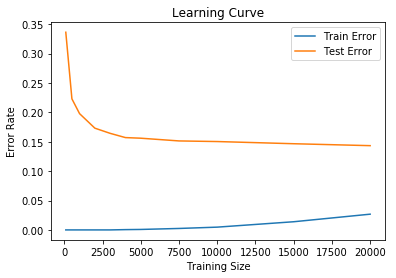

In [207]:
plt.figure()
plt.plot(train_sizes, train_errors, label='Train Error')
plt.plot(train_sizes, test_errors, label='Test Error')
plt.xlabel('Training Size')
plt.ylabel('Error Rate')
plt.title('Learning Curve')
plt.legend(loc="upper right")
plt.show()

We see the test error dramatically falling as the training size increases from 0 to 2000 samples. After that point, the test error curve remains relatively flat. Observing the train error curve, we notice it slowly increasing as training size largens. Looking at both the curves, a salient characteristic is the large gap between them. This is telling sign of high variance that would lead one to think an increase in training set size may alleviate some of this disparity. Alternatively, we could try diminishing the number of features in the data set. One such method could include removing the 10 most frequent words occurring in both of the sentiment classes. Overall, the Logistic Regression classifier looks to perform slightly better than did the Support Vector Machine model by about 4%.